#  Week 10: Support Vector Machines

### ** PRE-REQUISITES   **  
                          
**                      Before the class the Students should have a basic understanding of: ** 
                          *  Supervised Learning.
                          *  Scikit Learn Model fitting
                          *  Visualization in Python
                             

### ** LEARNING OBJECTIVE         **       
                          
   ** By the end of this lesson, students should be able to: **
                          *  Understand  and get the intution of SVM.
                          *  Use SVM for classification. 
                          *  Understand Kernel Trick.
                          *  Optimize SVM clasifier.
                          

Previously we introduced supervised machine learning.
There are many supervised learning algorithms available; here we'll go into brief detail one of the most powerful and interesting methods: **Support Vector Machines (SVMs)**.

In [159]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivating Support Vector Machines

Support Vector Machines (SVMs) are a powerful supervised learning algorithm used for **classification** or for **regression**. SVMs are a **discriminative** classifier: that is, they draw a boundary between clusters of data.

### Generate Data

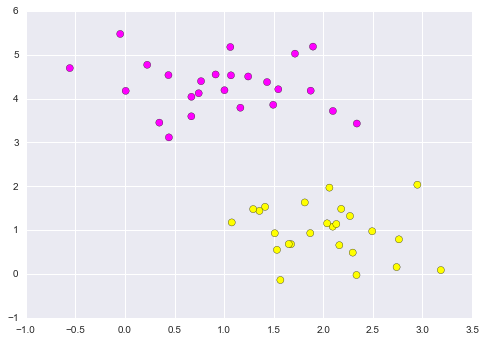

In [215]:
from sklearn.datasets.samples_generator import make_blobs

#Generate isotropic Gaussian blobs for clustering.
#centers = [ (100,50), (120, 55)]
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring');

* SVM  defines the optimal boundary to classify the two clusters.

A discriminative classifier attempts to draw a line between the two sets of data. Immediately we see a problem: such a line is ill-posed! For example, we could come up with several possibilities which perfectly discriminate between the classes in this example:

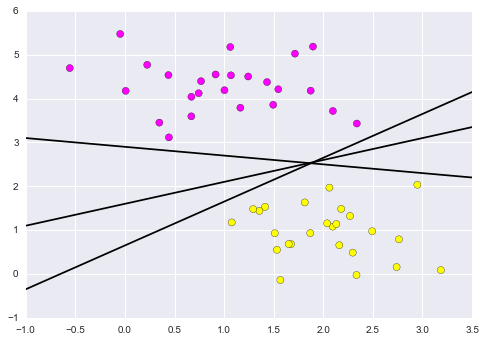

In [161]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separaters which perfectly discriminate between these samples. Depending on which you choose, a new data point will be classified almost entirely differently!

How can we improve on this?

### Best Seperating hyperplanes are the ones that Maximize the *Margin*

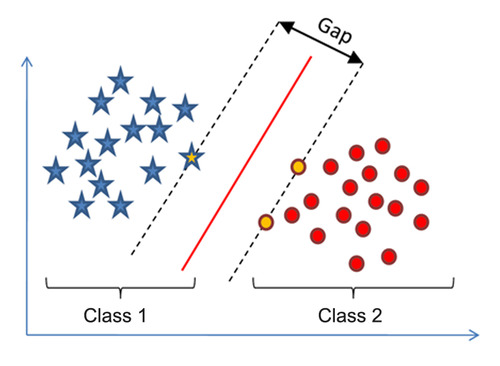

In [162]:
Image(filename='image2.jpg')

* Maximize the gap for the best classifier
* Optimal boundary based on support-vectors.

### Question 1:  Why is a bigger Margin Better ?


ANSWER:
1.  Think of the process that is  generating the data, Lets say there is NOISE in it. If the margin is bigger. New point will be on correct side of the line
2.  Better for out of sample data.

    

### SVM JOKE

What did one support vector say to another support vector?

"I feel so marginalized."

## Scikit-Learn 4-Step Modeling Pattern

* ** Step 1**: Import the class you plan to use
* ** Step 2**: "Instantiate" the "estimator"
* ** Step 3**: Fit the model with data (aka "model training")
* ** Step 4**: Predict the response for a new observation


#### Fitting a Support Vector Machine

Now we'll fit a Support Vector Machine Classifier to these points. While the mathematical details of the likelihood model are interesting, we'll let you read about those elsewhere. Instead, we'll just treat the scikit-learn algorithm as a black box which accomplishes the above task.

In [164]:
from sklearn.svm import SVC # "Support Vector Classifier"
clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [ ]:
### Visaulize the data and the decison boundary

In [165]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

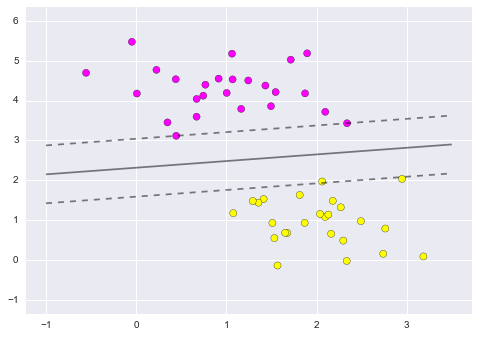

In [166]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

Notice that the dashed lines touch a couple of the points: these points are the pivotal pieces of this fit, and are known as the *support vectors* (giving the algorithm its name).
In scikit-learn, these are stored in the ``support_vectors_`` attribute of the classifier:

Let's use IPython's ``interact`` functionality to explore how the distribution of points affects the support vectors and the discriminative fit.
(This is only available in IPython 2.0+, and will not work in a static view)

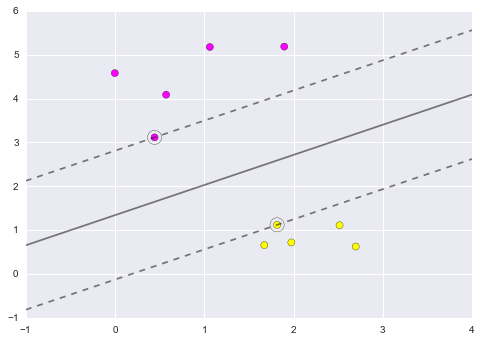

In [174]:
from IPython.html.widgets import interact

def plot_svm(N=10):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    clf = SVC(kernel='linear')
    clf.fit(X, y)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    plt.xlim(-1, 4)
    plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
    
interact(plot_svm, N=[10, 200], kernel='linear');

Notice the unique thing about SVM is that only the support vectors matter: that is, if you moved any of the other points without letting them cross the decision boundaries, they would have no effect on the classification results!

###  Kernel Methods 

Where SVM gets incredibly exciting is when it is used in conjunction with *kernels*.
To motivate the need for kernels, let's look at some data which is not linearly separable:

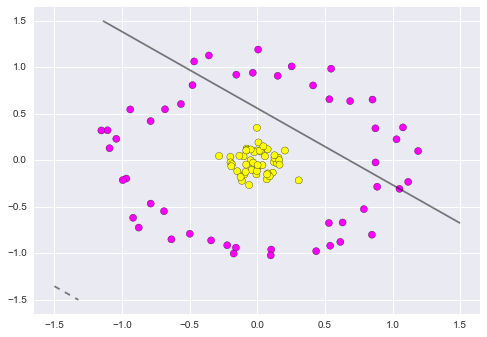

In [217]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

* Model not complex enough to fit the data we have

Clearly, no linear discrimination will ever separate these data.
One way we can adjust this is to apply a **kernel**, which is some functional transformation of the input data.

#### IDEA :
Increase the dimensions of feature vectors if they are non linearly seperable in low dimensions . Its quite likey  that they become seperable in  high dimensions.

For example, one simple model we could use is a **radial basis function**

In [218]:
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

If we plot this along with our data, we can see the effect of it:

####  Kernel Methods= Non Linear but effectively Linear

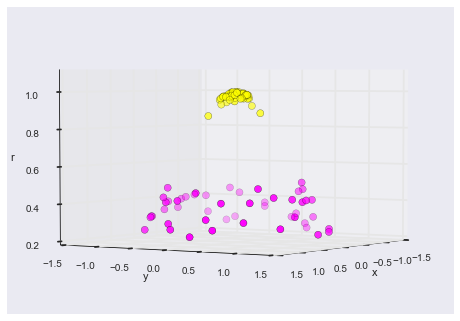

In [219]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

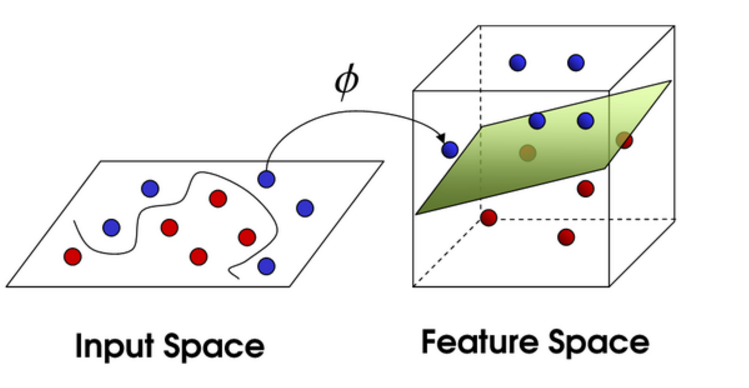

In [176]:
 Image(filename='image4.png')

* We can see that with this additional dimension, the data becomes trivially linearly separable!
* This is a relatively simple kernel; SVM has a more sophisticated version of this kernel built-in to the process. This is accomplished by using ``kernel='rbf'``, short for *radial basis function*:
* Kernel convert 2D data into 3D to make the data linealr seperable.

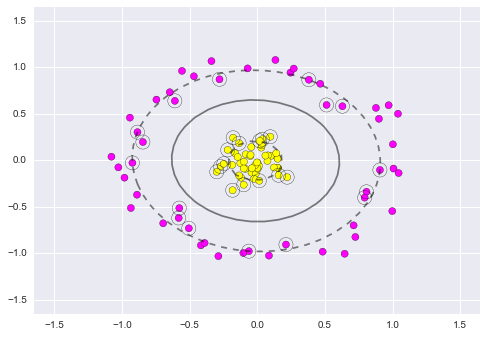

In [171]:
clf = SVC(kernel='rbf')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

* Kernel tricks alllows for classifcation of highly complex datasets

### Reacp
    * Intuition of SVM
    * Kernel trick
    * Model fitting and visualizing decision boundary

Time to make some predictions.

## Exercise :

### Tasks:
1. Optimize performance on Breast Cancer Data using SVC and GridSearchCV.
2. Use Confusion-Matrix  as the performance metric for the optimized-classifier.
3. Comment performance of the classifier.

In [225]:
SVC()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Solution:

### Read Data

In [202]:
# Read Breast Cancer Data
import pandas as pd
data=pd.read_csv("breast-cancer.csv")
data=data.drop(data.columns[0],axis=1)

### Seperate Features and Target columns

In [203]:
# Extract feature columns
feature_cols = list(data.columns[1:31])

# Extract target column 'passed'
target_col = data.columns[-0] 


# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = data[feature_cols]
y_all = data[target_col]

### Split Data for Cross Validation

In [204]:
from sklearn import cross_validation
#  Set the number of training points
num_train=400

# Set the number of testing points
num_test = X_all.shape[0] - num_train


#  Shuffle and split the dataset into the number of training and testing points above
rs = cross_validation.ShuffleSplit(568, n_iter=1,test_size=num_test, random_state=0)
for train_index, test_index in rs:
   # print("TRAIN:", train_index, "TEST:", test_index)
    X_train = X_all.loc[train_index,]
    X_test = X_all.loc[test_index,]
    y_train = y_all.loc[train_index,]
    y_test = y_all.loc[test_index,]
    
    
#X_train,X_test,y_train,y_test=train_test_split(X_all,y_all,test_size=num_train,random_state=4)
X_train_400 = X_train[:400]
y_train_400 = y_train[:400]
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 400 samples.
Testing set has 168 samples.


In [206]:
y_all[y_all=='B']='no'
y_all[y_all=='M']='yes'

### GridSearchCV SVC - Model Tuning

In [208]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score

param_grids = {"kernel":['rbf'],
               'gamma': [ 1e-4, 1e-5, 1e-6],
               'C': [1, 400, 500, 600, 700],
               }

clf_B1 = GridSearchCV(SVC(), param_grid= param_grids, cv=10,n_jobs= -1)
clf_B1.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gamma': [0.0001, 1e-05, 1e-06], 'C': [1, 400, 500, 600, 700], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

### Confusion-Matrix

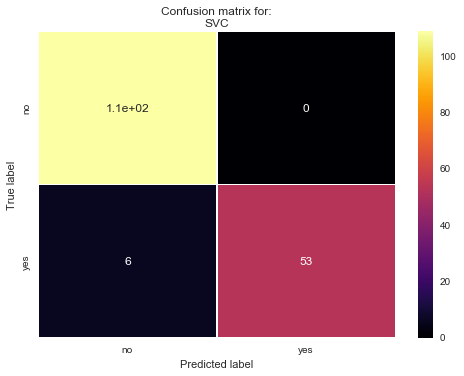

In [214]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix for a model
model = clf_B1
cm = confusion_matrix(y_test.values, model.predict(X_test))

# view with a heatmap
sns.heatmap(cm, annot=True, cmap='inferno', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'], linewidth=.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format("SVC"))

### No Free Lunch Theorem

* There is no one model that works best for every problem.
* The assumptions of a great model for one problem may not hold for another problem, so it is common in machine learning to try multiple models and find one that works best for a particular problem.

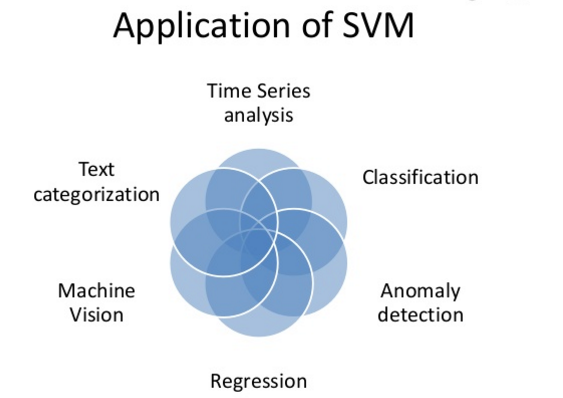

In [226]:
Image(filename='image5.png')

### NEXT  CLASS

* Naive bayes

### REFERENCES

1. [Jake Vanderplas](http://www.vanderplas.com) for PyCon 2015.
2. http://stackoverflow.com/questions/9480605/what-is-the-relation-between-the-number-of-support-vectors-and-training-data-and
3. https://www.quora.com/What-are-Kernels-in-Machine-Learning-and-SVM
4. https://www.reddit.com/r/MachineLearning/comments/15zrpp/please_explain_support_vector_machines_svm_like_i
5. http://www.dataschool.io/